## Data Exploration / Cleaning

In [2]:
import pandas as pd

# ============================
# 1. Load datasets
# ============================
train_df = pd.read_csv(r'F:\AI Projects\Regression Project\data\raw\train_data.csv')
eval_df = pd.read_csv(r'F:\AI Projects\Regression Project\data\raw\eval_data.csv')
metros = pd.read_csv(r'F:\AI Projects\Regression Project\data\raw\usmetros.csv')

pd.set_option('display.max_columns', None)  # to display all columns
pd.set_option('display.max_rows', None)     # to display all rows


In [3]:
print(train_df.shape)
print(eval_df.shape)

(585244, 39)
(149424, 39)


In [4]:
train_df.head(2)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Alpharetta
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh


In [5]:
metros.head(2)

,metro_fips,metro,metro_ascii,metro_full,county_name,county_fips,state_id,state_name,lat,lng,population
0,35620,New York,New York,"New York-Newark-Jersey City, NY-NJ",Suffolk,36103,NY,New York,40.7222,-74.0225,19498249
1,31080,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,6037,CA,California,34.2215,-118.1494,12799100


In [6]:
train_df['city_full'].value_counts().head()

city_full
New York-Newark-Jersey City       78020
Chicago-Naperville-Elgin          35344
Los Angeles-Long Beach-Anaheim    33840
Philadelphia-Camden-Wilmington    31396
DC_Metro                          29516
Name: count, dtype: int64

### Map cities to Lat/Long
- The goal is to use Lattitude and longitude instead of cities for our ML models

In [7]:
# ============================
# 2. Fix city name mismatches
# ============================
city_mapping = {
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas',
    'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial',
    'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos',
    'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach',
    'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont',
    'DC_Metro': 'Washington-Arlington-Alexandria',
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell'
}

In [8]:
def merge_city_lat_lng(df, metros):
    df = df.copy()
    metros = metros.copy()

    # Drop existing lat/lng
    df = df.drop(columns=["lat", "lng"], errors="ignore")

    # Normalize helper
    def normalize(s):
        return (
            str(s)
            .lower()
            .replace("-", " ")
            .replace("_", " ")
            .replace(".", "")
            .strip()
        )

    def first_word(s):
        return normalize(s).split()[0]

    # Create keys
    df["city_key"] = df["city_full"].apply(first_word)
    metros["metro_key"] = metros["metro_full"].apply(first_word)

    # DC override (required)
    df["city_key"] = df["city_key"].replace({"dc": "washington"})

    # ---- FIRST MERGE (fast path) ----
    df = df.merge(
        metros[["metro_key", "lat", "lng"]],
        how="left",
        left_on="city_key",
        right_on="metro_key"
    )

    df.drop(columns=["metro_key"], inplace=True)

    # ---- FALLBACK FOR REMAINING ROWS ----
    missing_mask = df["lat"].isna()

    if missing_mask.any():
        metro_lookup = metros.copy()
        metro_lookup["metro_norm"] = metro_lookup["metro_full"].apply(normalize)

        for idx in df[missing_mask].index:
            city = normalize(df.at[idx, "city_full"])

            match = metro_lookup[
                metro_lookup["metro_norm"].str.contains(city.split()[0])
            ]

            if not match.empty:
                df.at[idx, "lat"] = match.iloc[0]["lat"]
                df.at[idx, "lng"] = match.iloc[0]["lng"]

    # Final log
    still_missing = df.loc[df["lat"].isna(), "city_full"].unique()
    if len(still_missing) > 0:
        print(f"⚠️ Still missing lat/lng for: {list(still_missing)}")

    return df


In [9]:
train_df = merge_city_lat_lng(train_df, metros)
eval_df  = merge_city_lat_lng(eval_df, metros)


In [10]:
train_df.head(2)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,city_key,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Alpharetta,atlanta,33.7338,-84.3922
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh,pittsburgh,40.4744,-79.8632


In [11]:
train_df.isnull().sum()

date                            0
median_sale_price               0
median_list_price               0
median_ppsf                     0
median_list_ppsf                0
homes_sold                      0
pending_sales                   0
new_listings                    0
inventory                       0
median_dom                      0
avg_sale_to_list                0
sold_above_list                 0
off_market_in_two_weeks         0
city                            0
zipcode                         0
year                            0
bank                            0
bus                             0
hospital                        0
mall                            0
park                            0
restaurant                      0
school                          0
station                         0
supermarket                     0
Total Population                0
Median Age                      0
Per Capita Income               0
Total Families Below Poverty    0
Total Housing 

In [37]:
train_df = train_df.drop(columns=["city_full"], errors="ignore")
eval_df = eval_df.drop(columns=["city_full"], errors="ignore")

In [38]:
print(train_df.shape)
print(eval_df.shape)

(974026, 41)
(250982, 41)


In [49]:
train_df.head(2)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_key,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,atlanta,33.7338,-84.3922
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,pittsburgh,40.4744,-79.8632


## clean Duplicates

In [40]:
print(train_df.shape)


duplicated_rows = train_df[train_df.duplicated()].shape[0]
print("duplicated_rows:", duplicated_rows)

duplicated_rows = train_df[train_df.duplicated(subset=train_df.columns.difference(['date', 'year']))].shape[0]
print("duplicated_rows excluding date column:", duplicated_rows)

(974026, 41)
duplicated_rows: 0
duplicated_rows excluding date column: 0


In [41]:
# Delete duplicates
train_df = train_df.drop_duplicates(subset=train_df.columns.difference(['date', 'year']), keep=False)

print(train_df.shape)

duplicated_rows = train_df[train_df.duplicated()].shape[0]
print("duplicated_rows:", duplicated_rows)

duplicated_rows = train_df[train_df.duplicated(subset=train_df.columns.difference(['date', 'year']))].shape[0]
print("duplicated_rows excluding date column:", duplicated_rows)

(974026, 41)
duplicated_rows: 0
duplicated_rows excluding date column: 0


In [42]:
print(eval_df.shape)


duplicated_rows = eval_df[eval_df.duplicated()].shape[0]
print("duplicated_rows:", duplicated_rows)

duplicated_rows = eval_df[eval_df.duplicated(subset=eval_df.columns.difference(['date', 'year']))].shape[0]
print("duplicated_rows excluding date column:", duplicated_rows)

(250982, 41)
duplicated_rows: 0
duplicated_rows excluding date column: 0


In [43]:
# Delete duplicates
eval_df = eval_df.drop_duplicates(subset=eval_df.columns.difference(['date', 'year']), keep=False)

print(eval_df.shape)


duplicated_rows = eval_df[eval_df.duplicated()].shape[0]
print("duplicated_rows:", duplicated_rows)

duplicated_rows = eval_df[eval_df.duplicated(subset=eval_df.columns.difference(['date', 'year']))].shape[0]
print("duplicated_rows excluding date column:", duplicated_rows)

(250982, 41)
duplicated_rows: 0
duplicated_rows excluding date column: 0


## clean outliers

In [44]:
train_df['median_list_price'].describe()

count    9.740260e+05
mean     4.404776e+05
std      4.724440e+05
min      0.000000e+00
25%      1.898600e+05
50%      3.220000e+05
75%      5.290000e+05
max      1.584900e+07
Name: median_list_price, dtype: float64

In [45]:
import plotly.io as pio
pio.renderers.default = "browser"


In [46]:
import plotly.express as px

fig = px.violin(
    train_df,
    y="median_list_price",
    box=True,
    hover_name="median_list_price"
)

fig.update_layout(title="Violin Plot of Median List Price")
fig.show()


In [47]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), 'median_list_price')
print(top_1_percent.shape)
top_1_percent.head(10)

(9740, 41)


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_key,lat,lng
487891,2016-01-31,3200000.0,15849000.0,503.195647,2128.552474,2.0,8.0,2.0,22.0,330.0,0.900736,0.5,0.0,NY,7620,2016,10.0,0.0,11.0,0.0,46.0,18.0,69.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.369306e+06,new,40.7222,-74.0225
487892,2016-01-31,3200000.0,15849000.0,503.195647,2128.552474,2.0,8.0,2.0,22.0,330.0,0.900736,0.5,0.0,NY,7620,2016,10.0,0.0,11.0,0.0,46.0,18.0,69.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.369306e+06,new,29.7832,-89.9570
487893,2016-01-31,3200000.0,15849000.0,503.195647,2128.552474,2.0,8.0,2.0,22.0,330.0,0.900736,0.5,0.0,NY,7620,2016,10.0,0.0,11.0,0.0,46.0,18.0,69.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.369306e+06,new,41.3613,-72.8445
829408,2018-09-30,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.786193e+06,new,40.7222,-74.0225
829409,2018-09-30,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.786193e+06,new,29.7832,-89.9570
829410,2018-09-30,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.786193e+06,new,41.3613,-72.8445
839148,2018-10-31,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.779909e+06,new,40.7222,-74.0225
839149,2018-10-31,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.779909e+06,new,29.7832,-89.9570
839150,2018-10-31,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.779909e+06,new,41.3613,-72.8445
844135,2018-11-30,2000000.0,15624500.0,293.238603,1153.239602,2.0,1.0,2.0,9.0,280.5,0.837193,0.0,0.0,NY,11765,2018,7.0,0.0,0.0,2.0,21.0,10.0,18.0,2.0,2.0,732.0,49.7,125220.0,725.0,327.0,2528.0,1744000.0,355.0,11.0,723.0,723.0,290.0,1.771332e+06,new,40.7222,-74.0225


In [50]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), 'median_list_price')
print(top_1_percent['median_list_price'].value_counts().sort_index(ascending=False))

median_list_price
15849000.0      3
15624500.0      9
15500000.0      3
13995000.0      3
13100000.0     12
12772000.0      3
12500000.0     15
11900000.0      3
11495000.0      6
10747500.0      6
10692000.0     16
10000000.0      3
9999998.0       1
9934000.0       2
9697500.0       9
9547500.0       6
9394000.0       1
9350000.0       3
9100000.0       6
8900000.0       6
8793944.0      15
8750000.0       3
8700000.0      12
8500000.0       1
8495000.0       6
8142500.0       6
8000000.0       3
7995000.0       3
7988000.0       6
7947500.0       6
7941500.0       6
7750000.0      12
7695000.0       6
7522500.0       3
7495000.0       6
7472500.0       3
7450000.0       6
7442500.0       2
7424000.0       6
7374950.0       1
7300000.0       9
7299500.0       1
7245000.0       6
7199000.0      15
7000000.0       3
6999500.0       3
6995000.0     186
6945000.0       3
6847500.0       6
6844000.0      12
6822000.0       6
6720000.0       3
6700000.0       6
6665000.0       6
6650000.0 

- Investigate if median_list_price outliers are independent in distinct regions (for example if DC has different median_list_price)
- Drop outliers to keep things realistic and clean

In [51]:
# Clean outliers above 19M in both train and eval
train_df = train_df[train_df['median_list_price'] <= 19_000_000].copy()
eval_df = eval_df[eval_df['median_list_price'] <= 19_000_000].copy()

In [52]:
import plotly.express as px

fig = px.violin(train_df, y="median_list_price", box=True, hover_name="median_list_price")
fig.update_layout(title="Violin Plot of Median List Price")
fig.show()

In [53]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), 'median_list_price')
print(top_1_percent['median_list_price'].value_counts().sort_index(ascending=False))

median_list_price
15849000.0      3
15624500.0      9
15500000.0      3
13995000.0      3
13100000.0     12
12772000.0      3
12500000.0     15
11900000.0      3
11495000.0      6
10747500.0      6
10692000.0     16
10000000.0      3
9999998.0       1
9934000.0       2
9697500.0       9
9547500.0       6
9394000.0       1
9350000.0       3
9100000.0       6
8900000.0       6
8793944.0      15
8750000.0       3
8700000.0      12
8500000.0       1
8495000.0       6
8142500.0       6
8000000.0       3
7995000.0       3
7988000.0       6
7947500.0       6
7941500.0       6
7750000.0      12
7695000.0       6
7522500.0       3
7495000.0       6
7472500.0       3
7450000.0       6
7442500.0       2
7424000.0       6
7374950.0       1
7300000.0       9
7299500.0       1
7245000.0       6
7199000.0      15
7000000.0       3
6999500.0       3
6995000.0     186
6945000.0       3
6847500.0       6
6844000.0      12
6822000.0       6
6720000.0       3
6700000.0       6
6665000.0       6
6650000.0 

In [54]:
# ============================
# 4. Save cleaned datasets
# ============================
train_df.to_csv(
    r"F:\AI Projects\Regression Project\data\processed\cleaning_train.csv",
    index=False
)

eval_df.to_csv(
    r"F:\AI Projects\Regression Project\data\processed\cleaning_eval.csv",
    index=False
)


print("✅ Cleaning complete.")

✅ Cleaning complete.


## Housing prices exploration

In [55]:
df = train_df

In [56]:
df.head(3)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_key,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,atlanta,33.7338,-84.3922
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,pittsburgh,40.4744,-79.8632
4,2012-03-31,196000.0,198000.0,122.807018,124.060150,1.0,1.0,1.0,1.0,49.0,0.989899,0.000000,0.000000,PGH,15464,2012,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1515.0,45.1,18623.0,1508.0,692.0,484.0,79300.0,711.0,61.0,1489.0,1489.0,641.0,126572.277873,pittsburgh,40.4744,-79.8632


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8776\1748330476.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




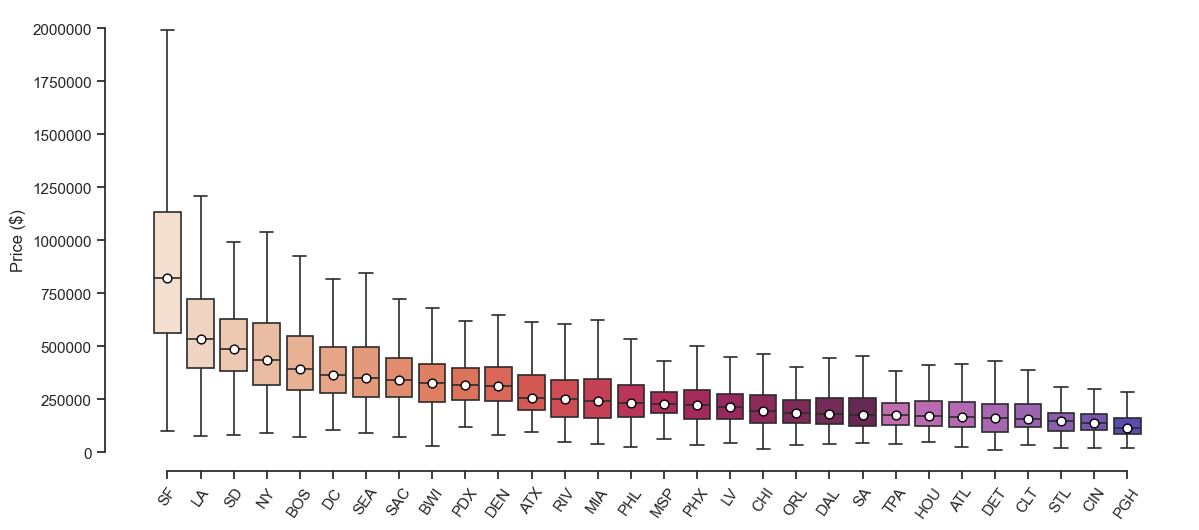

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import colorsys
sns.set_theme(style="whitegrid")           

# Boxplot of house prices for the cities, ordered by median price.

top_cities = df["city"].value_counts().head(30).index.tolist()
df_city    = df[df["city"].isin(top_cities)]
city_order = (
    df_city.groupby("city")["price"]
           .median()
           .sort_values(ascending=False)
           .index
)

base = sns.color_palette("rocket_r", len(city_order))

def lighten(color, amt=.4):
    h, l, s = colorsys.rgb_to_hls(*color)
    return colorsys.hls_to_rgb(h, min(1, l + amt*(1-l)), s)

palette = [
    lighten(c, .45) if i >= len(base) - 8 else c
    for i, c in enumerate(base)
]

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    x="city", y="price", data=df_city,
    order=city_order, palette=palette,
    showfliers=False, linewidth=1.2, ax=ax
)

medians = df_city.groupby("city")["price"].median().loc[city_order]
for tick, median in enumerate(medians):
    ax.scatter(tick, median, color="white", edgecolor="black", zorder=5, s=40)

ax.set_xlabel("")
ax.set_ylabel("Price ($)")
ax.tick_params(axis="x", rotation=55)
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="y", style="plain")

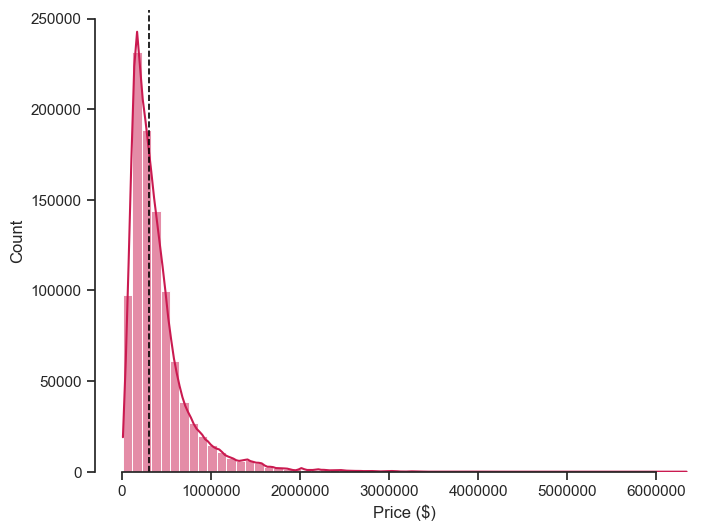

In [60]:
# Distribution of house prices across the dataset 

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df["price"].dropna(), bins=60, kde=True, color=sns.color_palette("rocket_r", 1)[0], ax=ax)
median_price = df["price"].median()
ax.axvline(median_price, ls="--", lw=1.2, color="black")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Count")
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
plt.show()